# Analytical Sliding Block Solutions
Creates (mostly) analytical solutions for rigid sliding block analyses with harmonic input.

## Purpose
During the development of the rigid block analysis for pyslammer, we discovered that the integration scheme we used was different than the one originally used in SLAMMER.
The main difference is that our approach integrated the full acceleration, velocity, and displacement signals of the base and block, only finding the differential displacement at the end.
Let's call this the "absolute integration approach" (AIA).
SLAMMER's integration scheme subtracts the block acceleration from the base acceleration and integrates the $\delta$ acceleration to find the $\delta$ velocity and $\delta$ displacement.
Let's call this the "difference integration approach" (DIA).
The DIA requires less computation, but also doesn't produce some of the resulting arrays that we'd like to see in the analysis output (e.g., absolute block and velocity).
Even though DIA doesn't produce those results by default, it could be altered to produce them.

Another difference between the methods is the numerical integration approach. 
Our AIA uses Velocity Verlet integration.
SLAMMER's DIA uses trapezoidal integration.
These differences are not inherent in the DIA/AIA differences.

The larger issue is that DIA and AIA produce slightly different results that accumulate with increasing input acceleration to yield acceleration ratio, frequency, and duration.
We suspect that AIA is a better approach than DIA, but we need a "correct" answer to compare both models to in order to confirm or deny our guess.

The analytical solutions for rigid block analysis with harmonic input will provide the basis for judging whether DIA or AIA are more accurate.

### Why Bother?
Sliding block methods are known to be poor representations of the physical displacements of slopes during earthquakes, so they're really only used as an idex of displacement.
One could argue that, since SLAMMER has been in use for many years and indicies are used to predict *relative* performance, it's more important for pyslammer to replicate SLAMMER's results than an analytical solution.

So why even bother comparing these integration methods?
The first reason is that it's interesting.
The second reason, which actually addresses the reasoning behind the question, is that sliding block methods, flawed as they are, are still widely used in the earthquake geotechnical engineering community and continue to be developed and improved. 
We hope that improvements to sliding block methods from the engineering community will be incorporated into pyslammer through open-source contributions.
Any such contributions should be able to take advantage of the best computational approximations available.
However, even if pyslammer's default integration approach ends up varying from SLAMMER's, an optional "compatability mode" will be availalbe using DIA for use cases where comparison with previous SLAMMER output is important.


## Approach
The analytical model uses one cycle of a sine wave acceleration input ($\ddot{u}_{base}$).
The sine wave has input frequency, $f$ (Hz):

$\ddot{u}_{base}(t) = \sin 2 \pi f t $

The start of sliding occurs at $t_1$, when $\ddot{u}_{base}$ is equal to the yield acceleration, $k_y$. 
By definition, the slope of the input velocity signal ($\dot{u}_{base}$) at this time is $\ddot{u}_{base}(t_1) = k_y$.
With this slope, and the cordinate ($t_1$,$\dot{u}_{base}(t_1)$), we can find the equation for the block velocity ($\dot{u}_{block}$) as:

$\dot{u}_{block}(t) = g k_y (t - t_1) - \dot{u}_{base}(t_1)$

The end of sliding occurs at $t_2$, when $\dot{u}_{block}(t)$ is equal to $\dot{u}_{base}(t)$. 
Unfortunately, solving for $t_2$ is non-trivial because it involves a transendental equation (it essentially boils down to $x = \cos x$).
The intersection between $\dot{u}_{block}(t)$ and $\dot{u}_{base}(t)$ can only be approximated numerically, which means the "analytical" solution presented here isn't truly analytical.
But since we'll be solving with a numerical solver with a tolerance of $1e^{-15}$ seconds, and the AIA and DIA models typically work with signals on the order of $1e^{-3}$ seconds, the numerical portion of the "analytical" sliding block doesn't disqualify it from acting as a basis of comparing the AIA and DIA models.

The analytical model only provides the accumulated displacement for a single cycle of motion.
When compared to DIA and AIA simulations with longer duration, the results should be multiplied by the number of cycles in the longer simulation.
The comparison is only valid if the number of cycles in the longer simulation is an integer value.

### Parameters
Two parameters control the analytical model behavior: $f$ and $k_y$.

For comparison with numeric integration results, the analytical model solution is computed for:

$f$ = `[0.5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]`

and

$k_y$ = `[0, 0.2, 0.4, 0.6, 0.8, 1.0]`



## Results
Unknown...


In [17]:
# Import libraries
import pickle as pkl
import numpy as np
import sympy as sym
sym.init_printing()

In [18]:
# Set up the parametric space
frequencies = np.array([0.5,1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
yield_accelerations = np.array([0,0.2,0.4,0.6,0.8,1.0])
combinations = np.array(np.meshgrid(frequencies, yield_accelerations)).T.reshape(-1, 2)


In [23]:
# Define symbols for analytical solution
# Three kinds of symbols are used:
# 1. Function names: the names of the functions as they would be written on the left-hand side of an equation. These are used purely for display purposes.
#    Function names have a single underscore at the beginning of the name (e.g. _u  or _v)
# 2. Function expressions: the definitions of functions using parameters. These are used to evaluate the functions.
# 3. Parameters: variables and constants used to define functions


# Define the function names
_abase, _vbase, _vblock = sym.symbols('nuprime, \dot{u}_{base}, \dot{u}_{block}', cls=sym.Function)
display(_abase, _vbase, _vblock)
time, freq, g, ky = sym.symbols('t f g k_y', real=True, positive=True)
t1, t2 = sym.symbols('t_1 t_2', real=True, positive=True)

nuprime

\dot{u}_{base}

\dot{u}_{block}

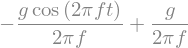

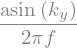

In [4]:
a = sym.sin(freq*2*sym.pi*time)
vo = g/2/sym.pi/freq#sym.symbols('v_o')#g*2*sym.pi
v = g*sym.integrate(a, time) + vo
t1 = sym.simplify(sym.solve(a-ky, time)[1])
display(a,v,t1)

In [5]:
a-ky

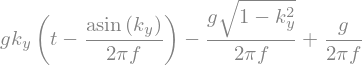

In [6]:
vb = g*ky*(time-t1) + v.subs(time, t1)
# vb = m(x-x1) + y1
display(vb)

In [7]:
a

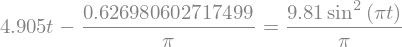

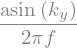

In [13]:
equation = sym.Eq(vb, v).subs(g, 9.81).subs(freq, 1).subs(ky, 0.5)
display(sym.simplify(equation))
t2 = sym.nsolve(equation, time, 2*np.pi)
display(t1,t2)

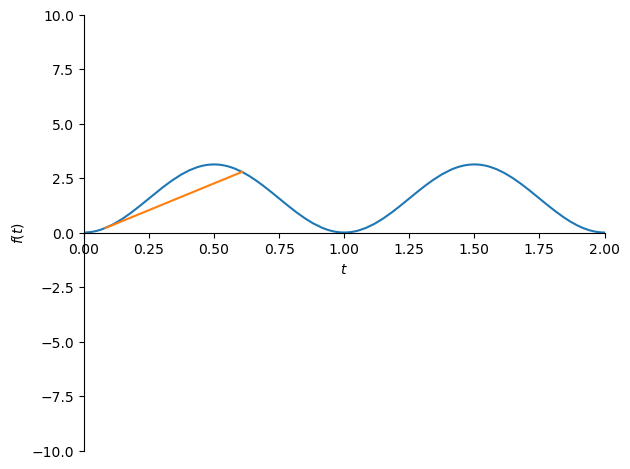

In [9]:
tmax = 2
v_def = v.subs(g, 9.81).subs(freq, 1)
vb_def = vb.subs(g, 9.81).subs(freq, 1).subs(ky, 0.5)
t1_def = t1.subs(freq, 1).subs(ky, 0.5)
p1 = sym.plot(v_def, (time, 0, tmax),xlim=(0, tmax), ylim=(-10, 10), show=False)
p2 = sym.plot(vb_def, (time, t1_def, t2), show=False)
# p3 = sym.plot(a.subs(freq,1), (time, 0, 20*np.pi), show=False)
p1.extend(p2)
# p1.extend(p3)
p1.show()

In [19]:
t1_def_val = float(t1_def)
t2_val = float(t2)
xb = sym.Integral(vb_def, (time, t1_def_val, t2_val))
x = sym.Integral(v_def, (time, t1_def_val, t2_val))
dx = x - xb
dx_val = dx.evalf()
dx_val

In [14]:
def create_harmonic_input_files(freq, resolution, cycles=10):
    duration = cycles/freq
    t = np.linspace(0, duration, int(duration*resolution*cycles))
    a = np.sin(np.pi*2*freq*t)
    data = np.column_stack((t, a))
    np.savetxt(f'sample_ground_motions/sine_{freq}_Hz_{resolution*freq}_sps.csv', data, delimiter=',', header=f'# Time Series: {freq} Hz sine wave \n # Time (s),Acceleration (g)')

def find_harmonic_solution(freq, ky, amax = 1, g = 9.81, plot=True):
        time, freq, g, ky = sym.symbols('t f g k_y', real=True, positive=True)
        t1, t2 = sym.symbols('t_1 t_2', real=True, positive=True)

        a = sym.sin(freq*2*sym.pi*time)
        vo = g/2/sym.pi/freq#sym.symbols('v_o')#g*2*sym.pi
        v = g*sym.integrate(a, time) + vo
        t1 = sym.simplify(sym.solve(a-ky, time)[1])

        vb = g*ky*(time-t1) + v.subs(time, t1)

        equation = sym.Eq(vb, v).subs(g, g).subs(freq, freq).subs(ky, ky)
        t2 = sym.nsolve(equation, time, 2*np.pi)

        t1_def = t1.subs(freq, freq).subs(ky, ky)
        t1_def_val = float(t1_def)
        t2_val = float(t2)
        vb_def = vb.subs(g, g).subs(freq, freq).subs(ky, ky)
        x = sym.Integral(v, (time, t1_def_val, t2_val))
        xb = sym.Integral(vb_def, (time, t1_def_val, t2_val))
        dx = x - xb
        dx_val = dx.evalf()
        return dx_val

def harmonic_solution_plot(a, ky, v, vb, dx, t1, t2, save=True):
    p1 = sym.plot(v, (time, 0, 20), show=False)
    p2 = sym.plot(vb, (time, t1, t2), show=False)
    p1.extend(p2)
    p1.show()

    p1 = sym.plot(vb, (time, t1, t2), show=False)
    p1.show()

    p1 = sym.plot(a, (time, 0, 20), show=False)
    p1.show()

    p1 = sym.plot(dx, (time, t1, t2), show=False)
    p1.show()

In [25]:
# Define the symbols
x, ky = sym.symbols('x ky')

# Define a
a = x**2

# Define the equation
equation = sym.Eq(a, ky)

# Display the equation
sym.pprint(equation)

NameError: name 't' is not defined